<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/atomai_atomnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a (fully convolutional) neural network and make predictions on experimental data

Prepared by Maxim Ziatdinov

E-mail: maxim.ziatdinov@ai4microscopy.com

## Install AtomAI

Install AtomAI:

In [ ]:
!pip install atomai

     |████████████████████████████████| 112kB 13.7MB/s 
     |████████████████████████████████| 194kB 19.4MB/s 
     |████████████████████████████████| 870kB 23.7MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=f2b558d2e0692ed6e47b031cf1262f4153a46a257861c4b45c5dd3dc58f96f81
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev


Import modules:

In [ ]:
import atomai as aoi
import numpy as np

## Single-class model

We start by (down)loading the training data, which is based on a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see *arXiv:2002.04245* and the associated notebook). The original image was ~3000 px x 3000 px. We randomly cropped about 2000 image-label pairs of 256 x 256 resolution and then applied different image "distortions" (noise, blurring, zoom, etc.) to each cropped image, treating all atoms as one class. Because the training data are just numpy arrays you can easily vizualize it with standard matplotlib functions. 

You can pass the training/test images and labels as 4 separate numpy arrays with the dimensions ```(n_images, n_channels=1, image_height, image_width)``` for training images, ```(n_images, n_channels=1, image_height, image_width)``` for labels with only one class of atoms (or all atoms treated as one class) and ```(n_images, image_height, image_width)``` for labels with multiple classes. Notice that even if you forget to add a pseudo-channel of 1 to your data, AtomAI will do it for you (and display a warning). After training a model, we will apply it to an experimental image from a different experiment/system (La-doped BFO) to see if it can find atoms in that previously unseen data. 

In [ ]:
download_link = 'https://drive.google.com/uc?id=1-0fXGXGY8jW11q2GdPZ2hmOhQ7-WNlnK'
!gdown -q $download_link -O 'training_data.npy'
dataset_1 = np.load('training_data.npy')
images_1 = dataset_1['X_train']
labels_1 = dataset_1['y_train']
images_test_1 = dataset_1['X_test']
labels_test_1 = dataset_1['y_test']
print(images_1.shape, labels_1.shape)

(1600, 1, 256, 256) (1600, 1, 256, 256)


After loading training data we can go straight to model training. This is because we believe that we already found an optimal neural network architecture for atom/defect finding ( see e.g. *Applied Physics Letters 115, 052902 (2019)*, *Advanced Functional Materials 29, 1904480 (2019)* ) and because we also found that the small improvements in the accuracy on the standard datasets like ImageNet due to the tweaks to the network's architecture are somewhat meaningless for the noisy experimental data as they usually are within the "error bar".

The model training is esentially one line of code. The final model weights will be saved automatically (by default they will be saved to the root directory, but you can change that).

Epoch 1/500 ... Training loss: 0.7395 ... Test loss: 0.7406 ... Train Accuracy: 0.2689 ... Test Accuracy: 0.1243 ... GPU memory usage: 4911/16130
Epoch 100/500 ... Training loss: 0.3715 ... Test loss: 0.3573 ... Train Accuracy: 0.7167 ... Test Accuracy: 0.6938 ... GPU memory usage: 4911/16130
Epoch 200/500 ... Training loss: 0.27 ... Test loss: 0.2678 ... Train Accuracy: 0.7514 ... Test Accuracy: 0.7489 ... GPU memory usage: 4911/16130
Epoch 300/500 ... Training loss: 0.2413 ... Test loss: 0.2293 ... Train Accuracy: 0.763 ... Test Accuracy: 0.7731 ... GPU memory usage: 4911/16130
Epoch 400/500 ... Training loss: 0.2095 ... Test loss: 0.2323 ... Train Accuracy: 0.7776 ... Test Accuracy: 0.7546 ... GPU memory usage: 4911/16130
Epoch 500/500 ... Training loss: 0.2186 ... Test loss: 0.2652 ... Train Accuracy: 0.7736 ... Test Accuracy: 0.726 ... GPU memory usage: 4911/16130
Model (final state) evaluation loss: 0.2193
Model (final state) IoU: 0.7694
Performing stochastic weights averaging...

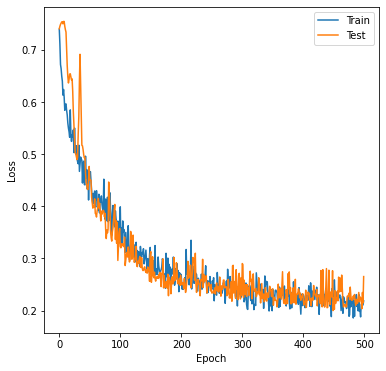

In [ ]:
# Initialize model
model = aoi.models.Segmentor(nb_classes=1)
# Train
model.fit(images_1, labels_1, images_test_1, labels_test_1, # training data
          training_cycles=500, compute_accuracy=True, swa=True # training parameters
) 

Now let's make a prediction on the image from a different experiment

*( the data is from our paper in *Applied Physics Letters 115, 052902 (2019) )*

In [ ]:
# Load "validation" data
expdata = dataset_1['validation_img']
# Get NN output with atomic coordinates
nn_output, coordinates_1 =model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.1107 seconds


Plot results:

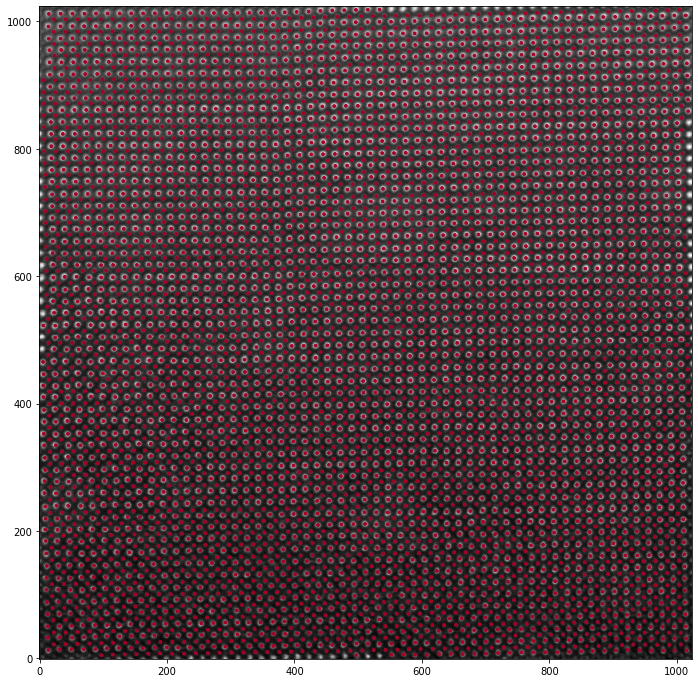

In [ ]:
aoi.utils.plot_coord(expdata, coordinates_1[0], fsize=12)

Looks like our model performed quite well on the previously unseen data and found some interesting local atomic distortions! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky. Notice that it is always a good idea to train your model on a diverse training set (e.g. many labeled expermental images, or simulated data for variety of atomic structures/positions). Here we used a training set made from a single image just to show a *quick* example of how atomnet module works. Such a model will not generalize very well.

Before training a multi-class model we show that it is possible to update predictions of a single model by splitting them into different classes of atoms (or defects) with a simple statistical analysis (more on the usage of ```atomstat``` module in this [notebook](https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomstat.ipynb). First, we collect intensities around the detected centers and then apply a meanshift clustering algorithms to the "feature vector" of intensities:

In [ ]:
updated_coordinates_1 = aoi.stat.update_classes(coordinates_1, expdata,
                                                    method="meanshift", q=.1)

PLot the results:

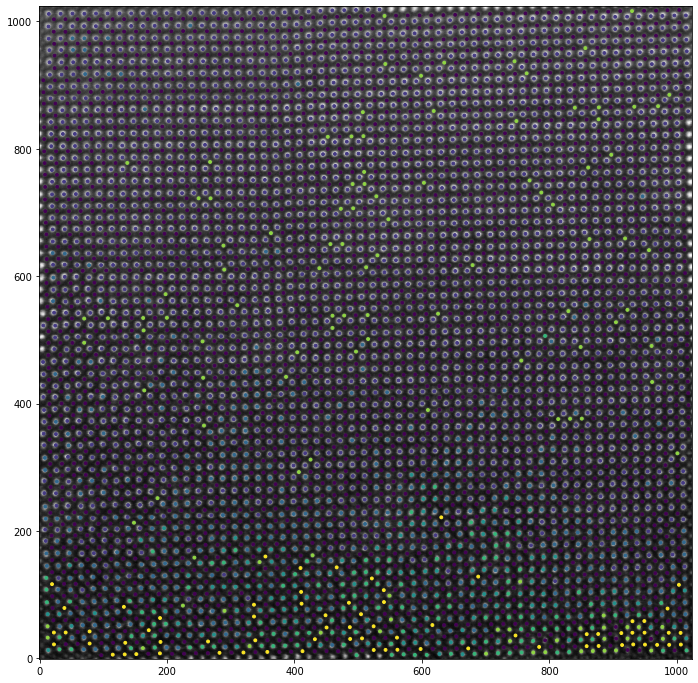

In [ ]:
aoi.utils.plot_coord(expdata, updated_coordinates_1[0], fsize=12, cmap="viridis")

The method was able to separate two distinct sublattices in most parts of the image but got confused by a sample thickness variation which were categorized in a separate class.

Now let's try to use surrounding of each atom to construct our "feature vector" and then apply Gaussian mixture model to it:

/usr/local/lib/python3.6/dist-packages/atomai/stat/multivar.py:94: UserWarning: The crop_size argument is deprecated. Use window_size to specify size of subimages
  UserWarning)



GMM components


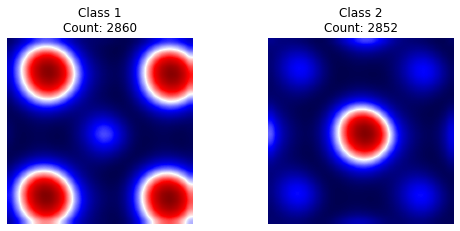

In [ ]:
updated_coordinates_1 = aoi.stat.update_classes(
    coordinates_1, expdata, method="gmm_local",
    window_size=28, n_components=2)

Plot the results:

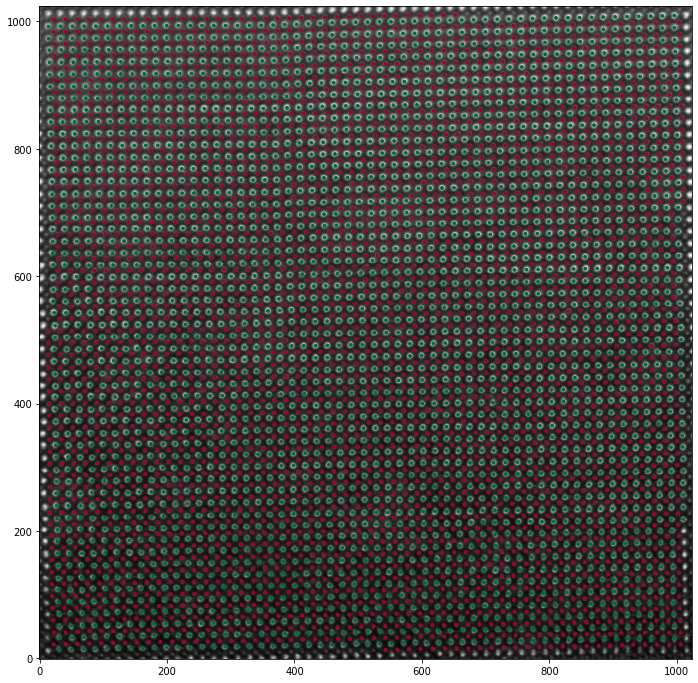

In [ ]:
aoi.utils.plot_coord(expdata, updated_coordinates_1[0], fsize=12)

Looks like we were able to separate the predicted atoms into two sublattices, even though the inital neural network was trained to categorize all the atoms as one class.

## Multi-class model

We now repeat the same routines but for the training data where different atomic elements correspond to different classes (the experimental image used for generation of this training data is the same as for the single-class case). The structure of the training data is similar to what we had in the single-class case (notice, however, that the labels are now a 3D array, without a channel dimension) and also can be easily vizualized with matplotlib.

(Down)load data:

In [ ]:
download_link = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
!gdown -q $download_link -O 'training_data-m.npy'
dataset_2 = np.load('training_data-m.npy')
images_2 = dataset_2['X_train']
labels_2 = dataset_2['y_train']
images_test_2 = dataset_2['X_test']
labels_test_2 = dataset_2['y_test']
print(images_2.shape, labels_2.shape)

(1656, 1, 256, 256) (1656, 256, 256)


Train a model:

Epoch 1/500 ... Training loss: 1.2721 ... Test loss: 1.2098 ... Train Accuracy: 0.0895 ... Test Accuracy: 0.0405 ... GPU memory usage: 4909/16130
Epoch 100/500 ... Training loss: 0.4096 ... Test loss: 0.3858 ... Train Accuracy: 0.7021 ... Test Accuracy: 0.6876 ... GPU memory usage: 4909/16130
Epoch 200/500 ... Training loss: 0.2926 ... Test loss: 0.2631 ... Train Accuracy: 0.7225 ... Test Accuracy: 0.7268 ... GPU memory usage: 4909/16130
Epoch 300/500 ... Training loss: 0.2417 ... Test loss: 0.2341 ... Train Accuracy: 0.7366 ... Test Accuracy: 0.7283 ... GPU memory usage: 4909/16130
Epoch 400/500 ... Training loss: 0.2184 ... Test loss: 0.2268 ... Train Accuracy: 0.7486 ... Test Accuracy: 0.7422 ... GPU memory usage: 4909/16130
Epoch 500/500 ... Training loss: 0.1973 ... Test loss: 0.2117 ... Train Accuracy: 0.7682 ... Test Accuracy: 0.7245 ... GPU memory usage: 4909/16130
Model (final state) evaluation loss: 0.2099
Model (final state) IoU: 0.7417
Performing stochastic weights averagin

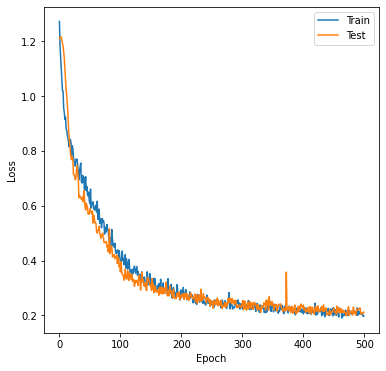

In [ ]:
# Initialize model
model = aoi.models.Segmentor(nb_classes=3)
# Train
model.fit(images_2, labels_2, images_test_2, labels_test_2, # training data
          training_cycles=500, compute_accuracy=True, swa=True # training parameters
) 

Get a prediction on the same image as in the single-class case:

In [ ]:
nn_output, coordinates_2 = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.1754 seconds


Plot results:

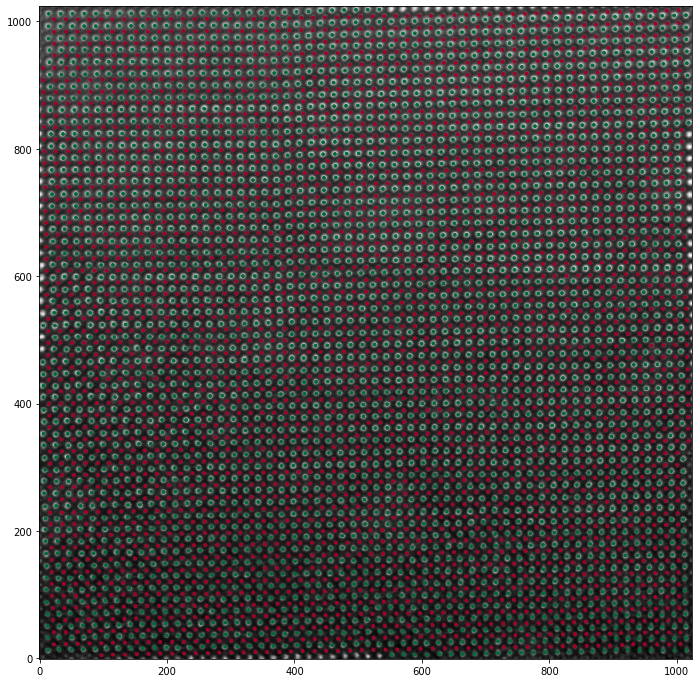

In [ ]:
aoi.utils.plot_coord(expdata, coordinates_2[0], fsize=12)

Our model can now distinguish between two different sublattices. This was achieved by changing the training set, while the deep learning model architecture remained the same. Notice that it seems like our some model misclassified some atoms in certain areas. It is worth noting that the sample is doped, which wasn't take into account in our training set. Therefore, there may be some "misclassification" due to the doping.